In [1]:
import tensorflow as tf
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import timeit
from sklearn import preprocessing

/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Batched data generator

In [2]:
def batch_generator(filename, batch_size):
    f = h5py.File(filename, 'r')
    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size > f['label'].shape[0]: #若batchsize不能整除的話，最後餘下的資料永遠不會讀出
            batch_count = 0
        start_idx = batch_count * batch_size
        end_idx = start_idx + batch_size
        batch_count += 1
        yield f['data'][start_idx : end_idx] , f['label'][start_idx : end_idx]
    f.close()

# Weight function

In [3]:
def w(shape): #weight
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='w')

def b(shape): #bias
    return tf.Variable(tf.constant(0.1,shape=shape), name='b')

def conv2d(x,w): #x:輸入影像，須為4維張量。 w:filter權重
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def maxpool2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# Model

In [4]:
pr = '10.00'
traindatafile_ =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdata_spec_pr'+pr+'.h5'
modelstore = '/Volumes/Mac/GW/model/model-resnet4.ckpt'

In [5]:
f = h5py.File(traindatafile_, 'r')
ll = len(f['data'])
print ll

5050


In [6]:
sample_rate = 8192
data_length = 8192 
T = data_length / sample_rate

nitv = 16.0
novl = 8.0
#f
lenf = int(sample_rate/nitv/2+1)
print 'lenth f =',lenf
#t
lent = int((nitv*T-1)*novl+1)
print 'lenth t =',lent

#idx of f=512
idx512 = (lenf-1)/8
print 'idx512=',idx512


batchSize = 24
print 'batch size =' ,batchSize
datasize = ll
totalBatchs = datasize/batchSize

c1fs = 8 #conv1 filter size
c1fn = 3 #conv1 output channel number
c2fs = 8 #conv2 filter size
c2fn = 3 #conv2 output channel number
c3fs = 4 #conv3 filter size
c3fn = 5 #conv3 output channel number
c4fs = 4 #conv4 filter size
c4fn = 5 #conv4 output channel number
dos1 = idx512+1 #1st dim of spectrogram
dos2 = lent #2nd din of spectrogram
lnn1 = 128 #layer1 neuron number
lnn2 = 32 #layer1 neuron number

lenth f = 257
lenth t = 121
idx512= 32
batch size = 24


In [7]:
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None, dos1, dos2], name='x')
    x_image = tf.reshape(x, [-1, dos1, dos2, 1]) #(筆數,頻率維度,時間維度,顏色維度)
    
with tf.name_scope('pool'):
    pool = maxpool2x2(x_image)
    print pool.shape.as_list()
    
with tf.name_scope('c1_conv'):
    w1 = w([c1fs ,c1fs ,1, c1fn])
    b1 = b([c1fn])
    conv1 = conv2d(pool, w1) + b1
    c1_conv = tf.nn.relu(conv1)
    print  conv1.shape.as_list()
    
with tf.name_scope('c2_conv'):
    w2 = w([c2fs ,c2fs , c1fn, c2fn])
    b2 = b([c2fn])
    conv2 = conv2d(c1_conv,w2) +b2
    print  conv2.shape.as_list()
    
    increase_dim_c2 = conv2.shape.as_list()[3]-pool.shape.as_list()[3]
    print  increase_dim_c2
    zeropadding_c2 = tf.zeros_like(conv2)[:,:,:,0:increase_dim_c2]
    print zeropadding_c2.shape.as_list()
    #shortcut connection
    c2_rl = conv2 + tf.concat([pool,zeropadding_c2], 3)
    c2_conv = tf.nn.relu(c2_rl)
    
with tf.name_scope('c2_pool'):
    c2_pool = maxpool2x2(c2_conv)
    
with tf.name_scope('c3_conv'):
    w3 = w([c3fs ,c3fs ,c2fn, c3fn])
    b3 = b([c3fn])
    conv3 = conv2d(c2_pool, w3) + b3
    c3_conv = tf.nn.relu(conv3)
    
with tf.name_scope('c4_conv'):
    w4 = w([c4fs ,c4fs ,c3fn, c4fn])
    b4 = b([c4fn])
    conv4 = conv2d(c3_conv, w4) + b4
    
    increase_dim_c4 = conv4.shape.as_list()[3]-c2_pool.shape.as_list()[3]
    zeropadding_c4 = tf.zeros_like(conv4)[:,:,:,0:increase_dim_c4]
    #shortcut connection
    c4_rl = conv4 + tf.concat([c2_pool,zeropadding_c4], 3)
    c4_conv = tf.nn.relu(c4_rl)
    

#neurons = dos1/8*dos2/8*c3fn
with tf.name_scope('D_flat'):
    D_Flat = tf.layers.Flatten()(c4_conv)

with tf.name_scope('D_hidden_layer1'):
    inputdim = D_Flat.shape.as_list()[1]
    wl1 = w([inputdim, lnn1])
    bl1 = b([lnn1])
    D_hidden1 = tf.nn.relu(tf.matmul(D_Flat, wl1)+bl1)
    
with tf.name_scope('D_hidden_layer2'):
    wl2 = w([lnn1, lnn2])
    bl2 = b([lnn2])
    D_hidden2 = tf.nn.relu(tf.matmul(D_hidden1, wl2)+bl2)
    
with tf.name_scope('output_layer'):
    wo = w([lnn2,2])
    bo = b([2])
    #y_predict = tf.sigmoid(tf.matmul(D_hidden2,wo)+bo)
    y_predict = tf.nn.softmax(tf.matmul(D_hidden2,wo)+bo)
    
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', shape=[None,2], name='y_label')
    #lossfunction = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    lossfunction = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(lossfunction)
    
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

[None, 17, 61, 1]
[None, 17, 61, 3]
[None, 17, 61, 3]
2
[None, 17, 61, 2]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# Training

In [30]:
def evaluate(trainEpochs,peakratio):

    start_time = timeit.default_timer()
    sess = tf.Session()

    saver = tf.train.Saver()

    try: #第一次之後執行
        saver.restore(sess, modelstore)
    except: #第一次跑時執行
        sess.run(tf.global_variables_initializer())

    traindatafile =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq512_pr'+str(peakratio)+'_mr<=10.h5'
    valdatafile = '/Volumes/Mac/GW/spec/overlap/5~75/validationdata_spec16-8_freq512_pr'+str(peakratio)+'_mr<=10.h5'
    
    
    bg = batch_generator(traindatafile, batchSize)
    fval = h5py.File(valdatafile, 'r')
    val_x = fval['data'][...]
    val_y = fval['label'][...]
    #np_utils.to_categorical
    for epoch in range(trainEpochs):
        for i in range(totalBatchs):
            #每次讀取100筆資料
            batch_x, batch_y = next(bg)
            #將feature和label輸入並計算執行圖
            sess.run(optimizer, feed_dict={x : batch_x, y_label : sess.run(tf.one_hot(batch_y, 2)) })
        #使用驗證資料計算一次epoch的loss和acc    
        loss, acc = sess.run([lossfunction,accuracy],feed_dict={x : val_x, y_label : sess.run(tf.one_hot(val_y, 2))})
    
        print 'Train Epoch:', '%02d'%(epoch+1), 'Loss=', '{:.9f}'.format(loss), 'Accuracy=',acc
    

    saver.save(sess, modelstore)

    fval.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    
    
def estimate(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    acc =  sess.run(accuracy, feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2)) })
    print 'acc :', acc
    stop_time = timeit.default_timer()
    print 'period of estimate =', stop_time - start_time, '(s)'
    return acc
    
def prediction_result(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data']
    print test_x.shape
    test_y = ftest['label']
    ftest.close()
    
    start_time = timeit.default_timer()
    predictresult = sess.run(tf.argmax(y_predict, 1), feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2))})
    stop_time = timeit.default_timer()
    print 'period of prediction =', stop_time - start_time, '(s)'
    return predictresult

In [9]:
def relation(n):
    d = '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.5_2time10_'
    rm = np.zeros([70,70])
    cm = np.zeros([2,2])
    for j in range(n):
        data =  d+str(j)+'_mr<=10.h5'
        test = h5py.File(data, 'r')
        test_par = test['parameter'][...]
        test_lab = test['label'][...]
        test.close()
        predict = prediction_result(data)
        cm += confusionmatrix(predict,test_lab)
        for i in range(len(test_par)):
            if test_par[i,0] != 0: #選擇有訊號的數據
                if test_lab[i] != predict[i]: #預測不正確則顏色加深
                    row = int(test_par[i,0]-5.5)
                    col =  int(test_par[i,1]-5.5)
                    rm[row,col] += 1.
    acc(cm)
    sensitivity(cm)
    false_alarm_rate(cm)
    scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    rmr = rm.reshape(70*70,1)
    rmrn = scale.fit_transform(rmr)
    rm = rmrn.reshape(70, 70)
    
    plt.imshow(rm, cmap='binary')
    tick_idx = [0,10,20,30,40,50,60]
    tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
    plt.yticks(tick_idx , tick_mass)
    plt.xticks(tick_idx , tick_mass)
    plt.xlabel('m2')
    plt.ylabel('m1')

def confusionmatrix(prediction_result,test_y):
    sess = tf.Session()
    cm = sess.run(tf.confusion_matrix(test_y, prediction_result))
    print 'confusionmatrix ='
    print cm
    return cm

def false_alarm_rate(cm):
    fp = cm[0,1].astype('float64')
    tn = cm[0,0].astype('float64')
    print 'false alarm rate =',fp/(fp+tn) #false alarm rate
    return fp/(fp+tn)

def sensitivity(cm):
    tp = cm[1,1].astype('float64')
    fn = cm[1,0].astype('float64')
    print 'sensitivity =',tp/(tp+fn) #sensitivity
    return tp/(tp+fn)

def acc(cm):
    print 'acc =',(cm[0,0]+cm[1,1])/np.sum(cm)
def summary():
    estimate()
    pr = prediction_result()
    cm = confusionmatrix(pr)
    false_alarm_rate(cm)
    sensitivity(cm)

In [13]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
th.create_dataset('sen', (8,), maxshape=(None,))
th.create_dataset('far', (8,), maxshape=(None,))
th.create_dataset('acc', (8,), maxshape=(None,))
th.create_dataset('pr', (8,), maxshape=(None,))

<HDF5 dataset "pr": shape (8,), type "<f4">

In [14]:
pr=2
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.314248055 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313448757 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313340366 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313298017 Accuracy= 1.0
period(s) = 179.253688097


In [15]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.313277900 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313271582 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313268453 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313266754 Accuracy= 1.0
period(s) = 325.816831112


In [16]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.313265711 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313264996 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313264489 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313264132 Accuracy= 1.0
period(s) = 487.481849909


In [10]:
pr=2
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.314450711 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313404351 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313315958 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313290238 Accuracy= 1.0
period(s) = 178.246795893


In [12]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][0]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][0]=far

sen = sensitivity(cm)
th['sen'][0]=sen

th['pr'][0]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
acc : 1.0
period of estimate = 11.9198110104 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 11.5591440201 (s)
confusionmatrix =
[[3682    0]
 [   0 2455]]
false alarm rate = 0.0
sensitivity = 1.0
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[2. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
pr=1.5 ; i=1
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.313366324 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313304603 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313295543 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313295096 Accuracy= 1.0
period(s) = 181.09274888


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.313287437 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313279897 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313275218 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313271791 Accuracy= 1.0
period(s) = 297.876804113


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.313279241 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313266665 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313264310 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313273937 Accuracy= 1.0
period(s) = 445.376435995


In [13]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.313263178 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313263148 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313263059 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313262969 Accuracy= 1.0
period(s) = 601.453629017


In [14]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
acc : 1.0
period of estimate = 9.77213311195 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 10.3744399548 (s)
confusionmatrix =
[[3682    0]
 [   0 2455]]
false alarm rate = 0.0
sensitivity = 1.0
[1. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 0. 0. 0. 0. 0. 0.]
[2.  1.5 0.  0.  0.  0.  0.  0. ]


In [15]:
pr=1.2 ; i=2
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.313943267 Accuracy= 0.9993333
Train Epoch: 02 Loss= 0.314692318 Accuracy= 0.999
Train Epoch: 03 Loss= 0.314960241 Accuracy= 0.998
Train Epoch: 04 Loss= 0.315153688 Accuracy= 0.998
period(s) = 184.43057394


In [16]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.314618796 Accuracy= 0.999
Train Epoch: 02 Loss= 0.314191848 Accuracy= 0.999
Train Epoch: 03 Loss= 0.313890129 Accuracy= 0.9993333
Train Epoch: 04 Loss= 0.313778132 Accuracy= 0.9993333
period(s) = 323.639317989


In [17]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.313671708 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313622713 Accuracy= 0.9996667
Train Epoch: 03 Loss= 0.313489467 Accuracy= 0.9996667
Train Epoch: 04 Loss= 0.313458115 Accuracy= 0.9996667
period(s) = 501.072643995


In [18]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.313425034 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313398659 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313385695 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313390613 Accuracy= 1.0
period(s) = 681.923896074


In [19]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
acc : 0.99918526
period of estimate = 13.3691301346 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 11.1446931362 (s)
confusionmatrix =
[[3678    4]
 [   1 2454]]
false alarm rate = 0.0010863661053775121
sensitivity = 0.9995926680244399
[1.         1.         0.99918526 0.         0.         0.
 0.         0.        ]
[0.         0.         0.00108637 0.         0.         0.
 0.         0.        ]
[1.         1.         0.99959266 0.         0.         0.
 0.         0.        ]
[2.  1.5 1.2 0.  0.  0.  0.  0. ]


In [10]:
pr=1 ; i=3
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.317530364 Accuracy= 0.9956667
Train Epoch: 02 Loss= 0.318826735 Accuracy= 0.9946667
Train Epoch: 03 Loss= 0.320268750 Accuracy= 0.99333334
Train Epoch: 04 Loss= 0.320191860 Accuracy= 0.993
period(s) = 171.532083988


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.319845021 Accuracy= 0.99366665
Train Epoch: 02 Loss= 0.318833947 Accuracy= 0.994
Train Epoch: 03 Loss= 0.317790359 Accuracy= 0.9953333
Train Epoch: 04 Loss= 0.319683254 Accuracy= 0.99333334
period(s) = 342.46666193


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.320025742 Accuracy= 0.993
Train Epoch: 02 Loss= 0.320415974 Accuracy= 0.99233335
Train Epoch: 03 Loss= 0.320598304 Accuracy= 0.9916667
Train Epoch: 04 Loss= 0.315899760 Accuracy= 0.99733335
period(s) = 460.931113005


In [13]:
pr=1 ; i=3
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.316611439 Accuracy= 0.99633336
Train Epoch: 02 Loss= 0.316892266 Accuracy= 0.996
Train Epoch: 03 Loss= 0.319708586 Accuracy= 0.99333334
Train Epoch: 04 Loss= 0.317193806 Accuracy= 0.9953333
period(s) = 603.37967205


In [14]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
acc : 0.997067
period of estimate = 11.3731510639 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 10.5231881142 (s)
confusionmatrix =
[[3680    2]
 [  16 2439]]
false alarm rate = 0.0005431830526887561
sensitivity = 0.9934826883910387
[1.         1.         0.99918526 0.997067   0.         0.
 0.         0.        ]
[0.         0.         0.00108637 0.00054318 0.         0.
 0.         0.        ]
[1.         1.         0.99959266 0.9934827  0.         0.
 0.         0.        ]
[2.  1.5 1.2 1.  0.  0.  0.  0. ]


In [10]:
pr=0.8 ; i=4
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.335085869 Accuracy= 0.97866666
Train Epoch: 02 Loss= 0.331026524 Accuracy= 0.982
Train Epoch: 03 Loss= 0.328719556 Accuracy= 0.98433334
Train Epoch: 04 Loss= 0.328095347 Accuracy= 0.985
period(s) = 169.509294033


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.328207254 Accuracy= 0.9856667
Train Epoch: 02 Loss= 0.328063279 Accuracy= 0.9856667
Train Epoch: 03 Loss= 0.328001946 Accuracy= 0.986
Train Epoch: 04 Loss= 0.325859338 Accuracy= 0.9866667
period(s) = 296.806728125


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.325443596 Accuracy= 0.98733336
Train Epoch: 02 Loss= 0.324876189 Accuracy= 0.988
Train Epoch: 03 Loss= 0.324491829 Accuracy= 0.98866665
Train Epoch: 04 Loss= 0.324290037 Accuracy= 0.989
period(s) = 446.162398815


In [13]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.324130327 Accuracy= 0.989
Train Epoch: 02 Loss= 0.324041963 Accuracy= 0.989
Train Epoch: 03 Loss= 0.323938996 Accuracy= 0.989
Train Epoch: 04 Loss= 0.323825836 Accuracy= 0.989
period(s) = 596.786413908


In [14]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
acc : 0.9915268
period of estimate = 11.2018179893 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 10.7055280209 (s)
confusionmatrix =
[[3661   21]
 [  31 2424]]
false alarm rate = 0.005703422053231939
sensitivity = 0.9873727087576375
[1.         1.         0.99918526 0.997067   0.9915268  0.
 0.         0.        ]
[0.         0.         0.00108637 0.00054318 0.00570342 0.
 0.         0.        ]
[1.         1.         0.99959266 0.9934827  0.9873727  0.
 0.         0.        ]
[2.  1.5 1.2 1.  0.8 0.  0.  0. ]


In [10]:
pr=0.7 ; i=5
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.336540461 Accuracy= 0.9773333
Train Epoch: 02 Loss= 0.335563421 Accuracy= 0.9766667
Train Epoch: 03 Loss= 0.337163180 Accuracy= 0.97533333
Train Epoch: 04 Loss= 0.337756962 Accuracy= 0.97533333
period(s) = 168.075651884


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.337845653 Accuracy= 0.975
Train Epoch: 02 Loss= 0.337086886 Accuracy= 0.97566664
Train Epoch: 03 Loss= 0.335121304 Accuracy= 0.977
Train Epoch: 04 Loss= 0.334341586 Accuracy= 0.9776667
period(s) = 292.793498039


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.333845496 Accuracy= 0.97966665
Train Epoch: 02 Loss= 0.333633512 Accuracy= 0.97933334
Train Epoch: 03 Loss= 0.333730072 Accuracy= 0.979
Train Epoch: 04 Loss= 0.334799558 Accuracy= 0.9773333
period(s) = 437.620516062


In [13]:
pr=0.7 ; i=5
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.335434735 Accuracy= 0.9763333
Train Epoch: 02 Loss= 0.335857958 Accuracy= 0.9763333
Train Epoch: 03 Loss= 0.335375041 Accuracy= 0.976
Train Epoch: 04 Loss= 0.335074455 Accuracy= 0.9776667
period(s) = 611.742298126


In [14]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
acc : 0.97474337
period of estimate = 13.2967181206 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 11.1981058121 (s)
confusionmatrix =
[[3582  100]
 [  55 2400]]
false alarm rate = 0.027159152634437807
sensitivity = 0.9775967413441955
[1.         1.         0.99918526 0.997067   0.9915268  0.97474337
 0.         0.        ]
[0.         0.         0.00108637 0.00054318 0.00570342 0.02715915
 0.         0.        ]
[1.         1.         0.99959266 0.9934827  0.9873727  0.97759676
 0.         0.        ]
[2.  1.5 1.2 1.  0.8 0.7 0.  0. ]


In [10]:
pr=0.6 ; i=6
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.368952274 Accuracy= 0.942
Train Epoch: 02 Loss= 0.369335234 Accuracy= 0.943
Train Epoch: 03 Loss= 0.373454511 Accuracy= 0.936
Train Epoch: 04 Loss= 0.375764400 Accuracy= 0.934
period(s) = 188.145440102


In [11]:
pr=0.6 ; i=6
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.372454137 Accuracy= 0.939
Train Epoch: 02 Loss= 0.371954471 Accuracy= 0.9393333
Train Epoch: 03 Loss= 0.369698256 Accuracy= 0.94233334
Train Epoch: 04 Loss= 0.369107515 Accuracy= 0.94233334
period(s) = 334.180644989


In [12]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.369389981 Accuracy= 0.94166666
Train Epoch: 02 Loss= 0.370203257 Accuracy= 0.941
Train Epoch: 03 Loss= 0.370615691 Accuracy= 0.9396667
Train Epoch: 04 Loss= 0.370548010 Accuracy= 0.939
period(s) = 513.073087931


In [13]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.371245593 Accuracy= 0.93833333
Train Epoch: 02 Loss= 0.372422248 Accuracy= 0.93766665
Train Epoch: 03 Loss= 0.375295579 Accuracy= 0.93633336
Train Epoch: 04 Loss= 0.379816025 Accuracy= 0.92966664
period(s) = 701.944985151


In [16]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
acc : 0.9415024
period of estimate = 13.3286428452 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 10.8654270172 (s)
confusionmatrix =
[[3611   71]
 [ 288 2167]]
false alarm rate = 0.019282998370450843
sensitivity = 0.8826883910386966
[1.         1.         0.99918526 0.997067   0.9915268  0.97474337
 0.9415024  0.        ]
[0.         0.         0.00108637 0.00054318 0.00570342 0.02715915
 0.019283   0.        ]
[1.         1.         0.99959266 0.9934827  0.9873727  0.97759676
 0.8826884  0.        ]
[2.  1.5 1.2 1.  0.8 0.7 0.6 0. ]


In [10]:
pr=0.5 ; i=7
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.425016671 Accuracy= 0.88566667
Train Epoch: 02 Loss= 0.428655773 Accuracy= 0.87866664
Train Epoch: 03 Loss= 0.429429024 Accuracy= 0.8793333
Train Epoch: 04 Loss= 0.431462944 Accuracy= 0.87733334
period(s) = 178.124872923


In [11]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.430381864 Accuracy= 0.8793333
Train Epoch: 02 Loss= 0.430053294 Accuracy= 0.8793333
Train Epoch: 03 Loss= 0.428162754 Accuracy= 0.8803333
Train Epoch: 04 Loss= 0.429959357 Accuracy= 0.87766665
period(s) = 317.519284964


In [12]:
pr=0.5 ; i=7
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.432264209 Accuracy= 0.876
Train Epoch: 02 Loss= 0.432939649 Accuracy= 0.8753333
Train Epoch: 03 Loss= 0.435314685 Accuracy= 0.87266666
Train Epoch: 04 Loss= 0.437928617 Accuracy= 0.8703333
period(s) = 452.16208005


In [13]:
evaluate(4,pr)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
Train Epoch: 01 Loss= 0.440962166 Accuracy= 0.86766666
Train Epoch: 02 Loss= 0.447873741 Accuracy= 0.8616667
Train Epoch: 03 Loss= 0.451872021 Accuracy= 0.85833335
Train Epoch: 04 Loss= 0.449616343 Accuracy= 0.86
period(s) = 608.828336


In [14]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
a=estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5')
th['acc'][i]=a

testd = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5', 'r')
testd_lab = testd['label'][...]
testd.close()
cm = confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'),
               testd_lab)

far = false_alarm_rate(cm)
th['far'][i]=far

sen = sensitivity(cm)
th['sen'][i]=sen

th['pr'][i]=pr

print th['acc'][...]
print th['far'][...]
print th['sen'][...]
print th['pr'][...]
th.close()

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
acc : 0.8750204
period of estimate = 12.7759311199 (s)
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 11.0725729465 (s)
confusionmatrix =
[[3567  115]
 [ 652 1803]]
false alarm rate = 0.031233025529603477
sensitivity = 0.7344195519348269
[1.         1.         0.99918526 0.997067   0.9915268  0.97474337
 0.9415024  0.8750204 ]
[0.         0.         0.00108637 0.00054318 0.00570342 0.02715915
 0.019283   0.03123303]
[1.         1.         0.99959266 0.9934827  0.9873727  0.97759676
 0.8826884  0.7344195 ]
[2.  1.5 1.2 1.  0.8 0.7 0.6 0.5]


INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 10.1940310001 (s)
confusionmatrix =
[[ 528   17]
 [1297 3613]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 10.3532891273 (s)
confusionmatrix =
[[ 532   13]
 [1263 3647]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 10.4317409992 (s)
confusionmatrix =
[[ 528   17]
 [1330 3580]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 9.96110296249 (s)
confusionmatrix =
[[ 526   19]
 [1286 3624]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 10.3136320114 (s)
confusionmatrix =
[[ 530   15]
 [1283 3627]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 9.62368917465 (s)
confusionmatrix =
[[ 523   22]


confusionmatrix =
[[ 527   18]
 [1291 3619]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
period of prediction = 11.6350178719 (s)
confusionmatrix =
[[ 534   11]
 [1200 3710]]
acc = 0.7623831347387717
sensitivity = 0.7392912423625254
false alarm rate = 0.029577981651376147


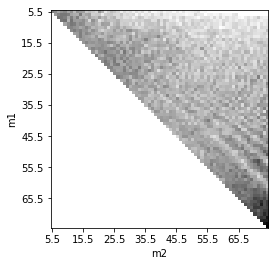

In [15]:
relation(50)

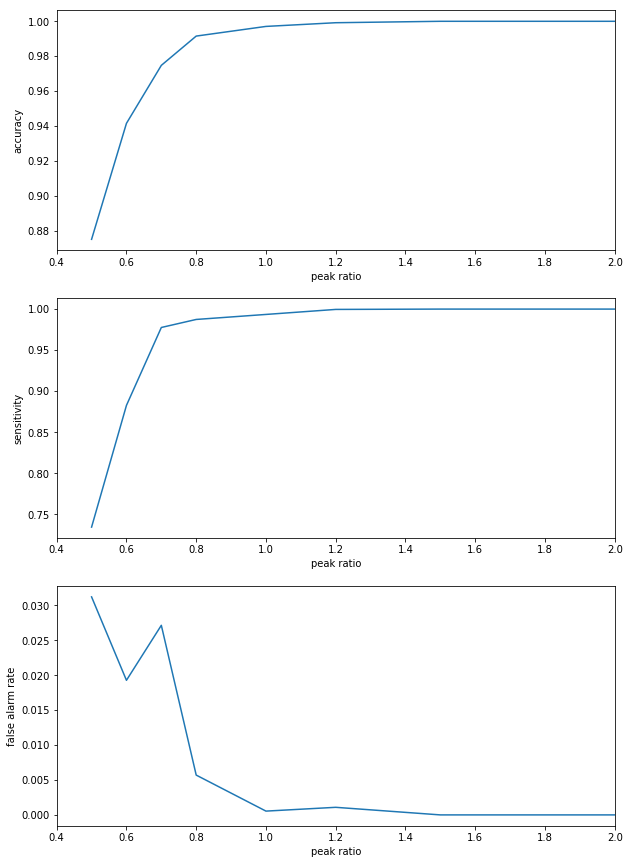

In [16]:
th = h5py.File('/Volumes/Mac/GW/traininghistory/traininghistory-resnet4', 'a')
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(th['pr'][...],th['acc'][...])
plt.xlabel('peak ratio')
plt.ylabel('accuracy')
plt.xlim(0.4,2)
plt.subplot(312)
plt.plot(th['pr'][...],th['sen'][...])
plt.xlabel('peak ratio')
plt.ylabel('sensitivity')
plt.xlim(0.4,2)
plt.subplot(313)
plt.plot(th['pr'][...],th['far'][...])
plt.xlabel('peak ratio')
plt.ylabel('false alarm rate')
plt.xlim(0.4,2)
th.close() 

In [31]:
def mass_relative_error(multi, mass_relate_error_data):
    rm = np.zeros([70,70])
    rmf = h5py.File('/Volumes/Mac/GW/mass_relative_error/{0}.h5'.format(modelname), 'a')
    rmf.create_dataset('rm', (70,70))
    
    test = h5py.File(mass_relate_error_data, 'r')
    test_par = test['parameter'][...]
    test_lab = test['label'][...]
    test.close()
    predict = prediction_result(mass_relate_error_data)
    for i in range(len(test_par)):
        if test_lab[i] != predict[i]: #預測不正確則顏色加深
            row = int(test_par[i,0]-5.5)
            col =  int(test_par[i,1]-5.5)
            rm[row,col] += 1.
    rmf['rm'][...] = rm/multi
    rmf.close()

In [28]:
modelname='resnet4'
mass_relative_error(50, '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdata_spec_error_relate_mass.h5')

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-resnet4.ckpt
(100, 33, 121)
period of prediction = 0.194284915924 (s)


Text(0,0.5,'m1')

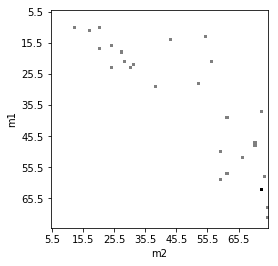

In [29]:
rmf=h5py.File('/Volumes/Mac/GW/mass_relative_error/{0}.h5'.format(modelname), 'r')
rm=rmf['rm'][...]
plt.imshow(rm, cmap='binary')
tick_idx = [0,10,20,30,40,50,60]
tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
plt.yticks(tick_idx , tick_mass)
plt.xticks(tick_idx , tick_mass)
plt.xlabel('m2')
plt.ylabel('m1')